In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import warnings

In [60]:
# Download data

vix_data = yf.download("^VIX", start="2021-01-01", end="2025-01-01", progress=False)[('Close', '^VIX')].to_frame()
vix_data.columns = ['Close']
vix_data.fillna(method="ffill", inplace=True)

print(vix_data.head())

                Close
Date                 
2021-01-04  26.969999
2021-01-05  25.340000
2021-01-06  25.070000
2021-01-07  22.370001
2021-01-08  21.559999


C:\Users\felip\AppData\Local\Temp\ipykernel_7420\624858654.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vix_data.fillna(method="ffill", inplace=True)


In [ ]:
#vix_data = pd.read_csv("VIX_prices.csv", parse_dates=['Date'] ,sep=",")
#vix_data.set_index('Date', inplace=True)
#vix_data.head()

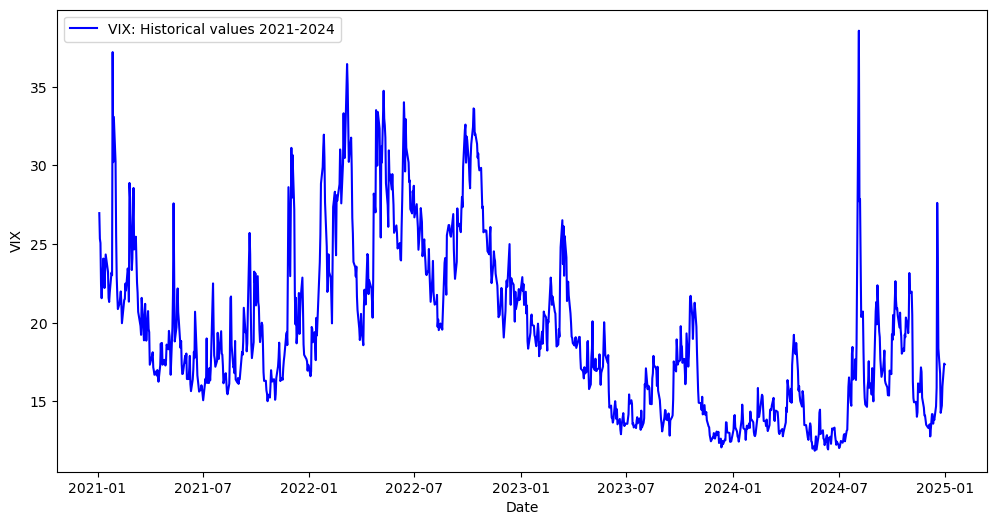

In [57]:
# Plot time series

plt.figure(figsize=(12,6))
plt.plot(vix_data['Close'], label= "VIX: Historical values 2021-2024", color="blue")
plt.xlabel("Date")
plt.ylabel("VIX")
plt.legend()
plt.show()

In [ ]:
#  Scaling

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()

vix_data['Scaled'] = scaler.fit_transform(vix_data[['Close']])

,Close,Scaled
Date,,
2021-01-04,26.969999,0.565706
2021-01-05,25.340000,0.504680
2021-01-06,25.070000,0.494571
2021-01-07,22.370001,0.393486
2021-01-08,21.559999,0.363160
...,...,...
2024-12-24,14.270000,0.090228
2024-12-26,14.730000,0.107450
2024-12-27,15.950000,0.153126


In [97]:
# Sequences

sequences_length = 30

def create_sequences(data, seq_length):

    Sequences = []
    targets = []

    for i in range(len(data)-seq_length):

        Sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])

    return np.array(Sequences), np.array(targets)

X_vix, y_vix = create_sequences(vix_data['Scaled'].values, sequences_length)

X_vix = np.expand_dims(X_vix, axis=2)

print(X_vix.shape)

X_train, X_test, y_train, y_test = train_test_split(X_vix, y_vix, test_size=0.2, shuffle=False)

(975, 30, 1)


In [93]:
# Preparing for training

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [96]:
warnings.filterwarnings("ignore")

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape = input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation="relu"),
        Dense(1)
    ])

    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

# Define model

lstm_vix = build_lstm_model((X_train.shape[1],X_train.shape[2]))

# Print summary

lstm_vix.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [98]:
# train the model

history = lstm_vix.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0796 - val_loss: 0.0140
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0149 - val_loss: 0.0143
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0137 - val_loss: 0.0135
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0115 - val_loss: 0.0134
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0097 - val_loss: 0.0133
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0095 - val_loss: 0.0128
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0093 - val_loss: 0.0126
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0094 - val_loss: 0.0127
Epoch 9/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0097 - val_loss: 0.0118
Epoch 10/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0079 - val_loss: 0.0118
Epoch 11/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0073 - val_loss: 0.0113
Epoch 12/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0

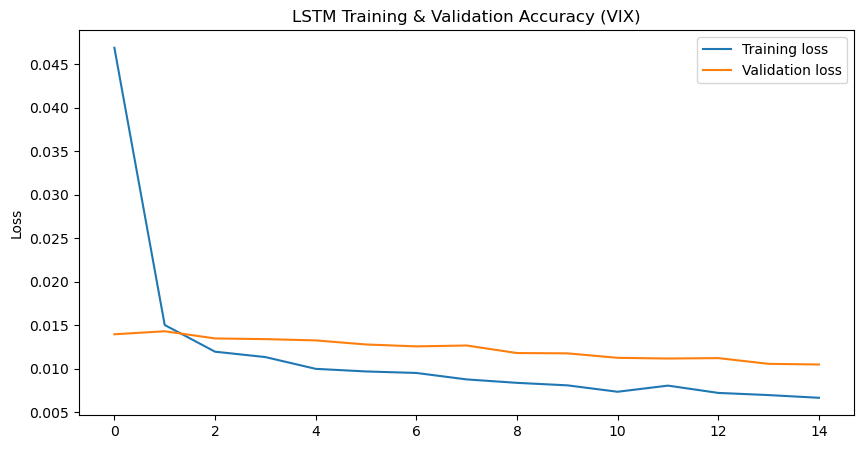

In [99]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label = "Training loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.legend()
plt.title("LSTM Training & Validation Accuracy (VIX)")
plt.ylabel("Loss")
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


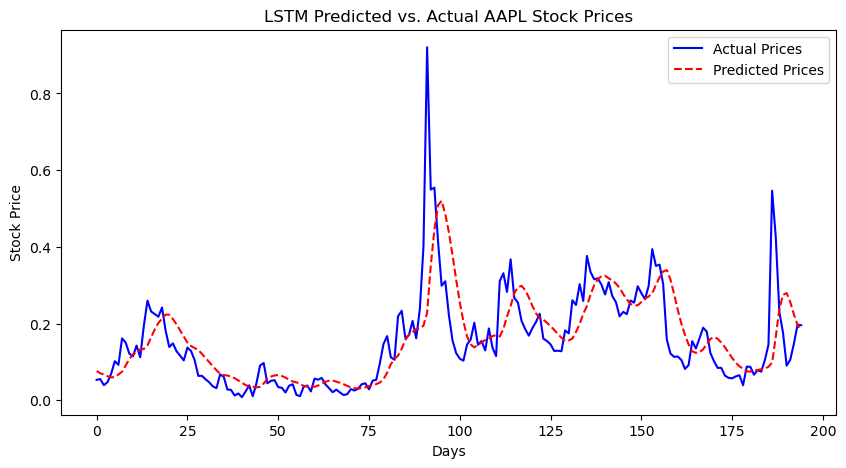

In [100]:
# Get model predictions on the test set
y_pred = lstm_vix.predict(X_test)

# Scale data back to original range

scaler.fit(y_train.reshape(-1, 1))
y_pred_rescaled = scaler.inverse_transform(y_pred) 
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)) 

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label="Actual Prices", color="blue")
plt.plot(y_pred_rescaled, label="Predicted Prices", color="red", linestyle="dashed")
plt.legend()
plt.title("LSTM Predicted vs. Actual AAPL Stock Prices")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.show()